In [87]:
import numpy as np
import matplotlib.pyplot as plt


In [88]:
I_0 = 1 #for simplicity and could be adapted with weights
eta = 376.7

def U_dipole(k,l,theta):
    U = (eta*k**2)/(32*np.pi**2)*(l**2)*np.sin(theta)**2
    return U

def U_standing_wave(k,l, theta):
    U = (eta)/(8*np.pi**2*np.sin(theta)**2)*(np.cos(np.cos(theta)*(k*l)/2)-np.cos((k*l)/2))**2
    return U

def U_half_wave(k, l, theta):
    k = 2*np.pi
    l= 1/2
    return U_standing_wave(k, l, theta)

def get_U(atype,k,l,theta):
    """
    1: dipole
    2: standing wave
    3: half wave
    """
    if atype == 1:
        return U_dipole(k,l,theta)
    elif atype == 2:
        return U_standing_wave(k,l,theta)
    elif atype == 3:
        return U_half_wave(k,l,theta)
    else:
        return None
    

In [89]:
def convert_in_dB(U):
    return 10*np.log10(U)

In [90]:
def C_k(k,l, weights, positions, theta, phi):
    """
    k: wavenumber
    l: length of the antennas !in units of lambda!
    weights: list of each weight a_n
    positions: list of position of each antenna (x, y, z) !coordinates in units of lambda!
    """
    N = len(weights) #length of the array i.e number of element in the array
    k_x = k*np.sin(theta)*np.cos(phi)
    k_y = k*np.sin(theta)*np.sin(phi)
    k_z = k*np.cos(theta)
    wavelength = 2*np.pi/k
    C = 0
    for n in range(0, N):
        x = positions[n][0]*wavelength
        y = positions[n][1]*wavelength
        z = positions[n][2]*wavelength
        term1 = k_x*x
        term2 = k_y*y
        term3 = k_z*z
        C += weights[n]*np.exp(1j*(term1+term2+term3))
        
    
    return C

def power_gain(k,l, weights, positions, theta, phi, atype):
    """
    atype: antenna type(0: power gain only 1: dipole, 2: standing wave antenna, 3: half wave antenna)
    """
    C = C_k(k,l, weights, positions, theta, phi)
    C = abs(C)**2
    if atype != 0:
        U = get_U(atype,k,l,theta)
        C = U*C
    return C

def power_gain_dB(g):
    # convert to dB, clip at –40 dB, then normalize to [0,1]
    g_db = 10 * np.log10(np.clip(g, 1e-12, None))
    g_db = np.clip(g_db, -45, None)
    return (g_db + 45) / 45 
def plot_powergain_2D(k, l, weights, positions, atype):
    """
    MATLAB‐style polar plot of normalized radiation pattern,
    now splitting into [-π,0] (red) and [0,π] (blue).
    """
    # 1) compute linear gain over [0, π]
    theta   = np.pi/2
    phi_pos = np.linspace(0, np.pi, 401)
    g_pos   = power_gain(k, l, weights, positions, theta, phi_pos, atype)
    g_pos  /= np.max(g_pos)

    # 2) mirror to [-π,0]
    phi_neg = -phi_pos[1:]      # drop the zero so it’s not duplicated
    g_neg   = power_gain(k, l, weights, positions, theta, phi_neg, atype)
    g_neg  /= np.max(g_neg)

    # 3) convert to dB & normalize
    g_db_pos = power_gain_dB(g_pos)
    g_db_neg = power_gain_dB(g_neg)

    # 4) start polar plot
    fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection':'polar'})
    ax.set_theta_zero_location('E')   # φ=0 at the right
    ax.set_theta_direction(-1)        # clockwise

    # outer circle
    th = np.linspace(0, 2*np.pi, 360)
    ax.plot(th, np.ones_like(th), color='gold', linewidth=2)

    # concentric rings
    for r, col in zip([0.75, 0.5, 0.25], ['purple','green','purple']):
        ax.plot(th, [r]*len(th), linestyle=':', color=col, linewidth=1)

    # radial rays
    for ang in np.deg2rad(np.arange(0,360,45)):
        ax.plot([ang, ang],[0,1], linestyle=':', color='gold', linewidth=1)

    # plot the two halves
    ax.plot(phi_pos,   g_db_pos, linewidth=1)       # [0,π] in default (blue)
    ax.plot(phi_neg,   g_db_neg, color='red', linewidth=1)  # [-π,0] in red

    # custom angle labels
    angles = [0,45,90,135,180,225,270,315]
    labels = ['0°','45°','90°','135°','180°','-135°','-90°','-45°']
    ax.set_xticks(np.deg2rad(angles))
    ax.set_xticklabels(labels, fontsize=12)

    # radial ticks but hide labels
    ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
    ax.set_yticklabels([])
    ax.grid(False)

    ax.set_title('Normalized Radiation Pattern (dB)', va='bottom', fontsize=14)
    plt.show()


zi [0.96858316-0.24868989j 0.87630668-0.48175367j 0.72896863-0.68454711j
 0.53582679-0.84432793j 0.30901699-0.95105652j] kd 0.6283185307179586 psi [-0.25132741 -0.50265482 -0.75398224 -1.00530965 -1.25663706]


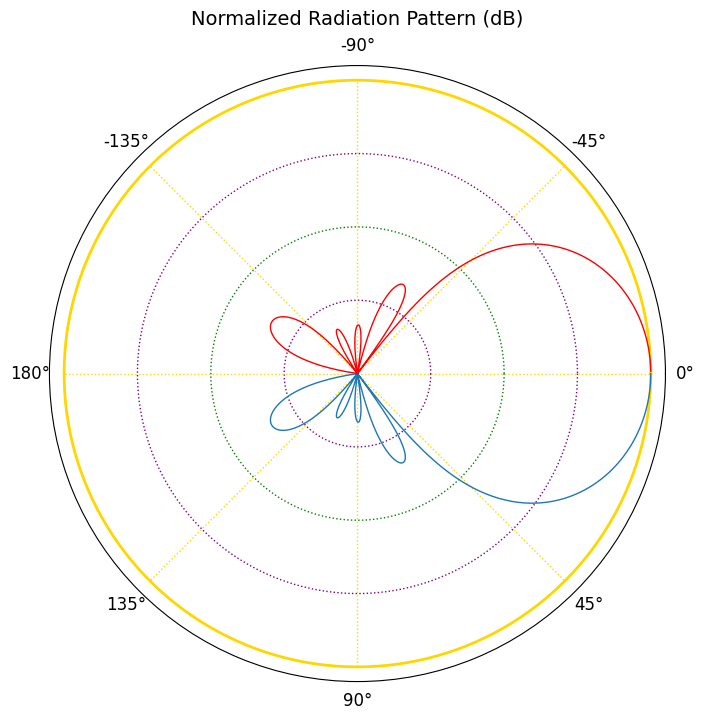

[ 1.        +0.00000000e+00j  0.80901699-5.87785252e-01j
  0.30901699-9.51056516e-01j -0.30901699-9.51056516e-01j
 -0.80901699-5.87785252e-01j -1.        -1.22464680e-16j]


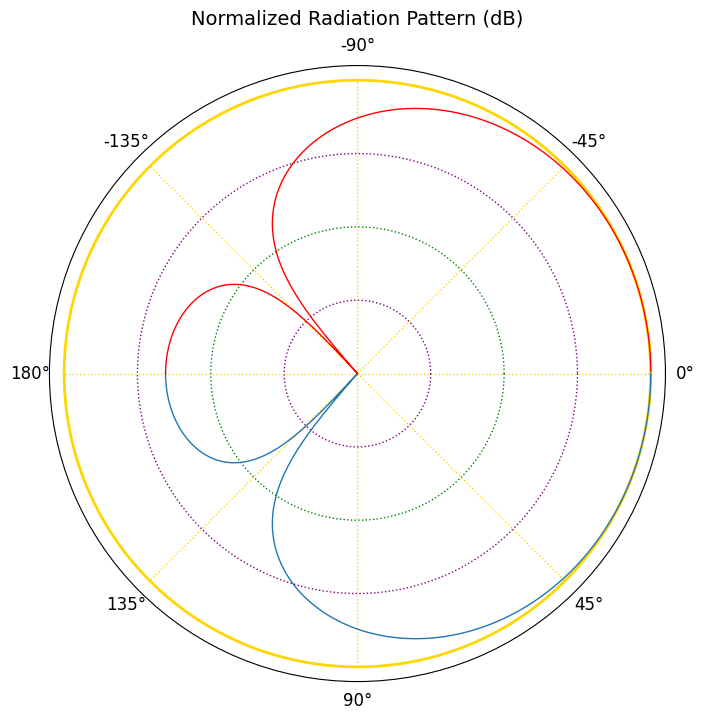

In [91]:
d = 1/10
N = 6

# define k, l
k = 2*np.pi    # λ = 1
l = 1          # element length = 1 λ

# pick N-1 zeros to get N weights
i = np.arange(1, N)                  
kd = k*d
psi = -2*kd*i/(N-1)      
zi  = np.exp(1j*psi)


print('zi',zi , 'kd',kd , 'psi',psi, )

p       = np.poly(zi)    # length N
weights = p[::-1]     # length N
n       = np.arange(N)   # now matches

# apply steering
alpha      = 0
psi_shift  = k*d*np.cos(np.deg2rad(alpha))
weights   *= np.exp(-1j*n*psi_shift)

# geometry
positions = [(n_i*d, 0, 0) for n_i in n]

# finally call your plot function
plot_powergain_2D(k, l, weights, positions, 0)

weights = [1]*N
alpha      = 0
psi_shift  = k*d*np.cos(np.deg2rad(alpha))
weights   *= np.exp(-1j*n*psi_shift)
print(weights)
plot_powergain_2D(k, l, weights, positions, 0)

